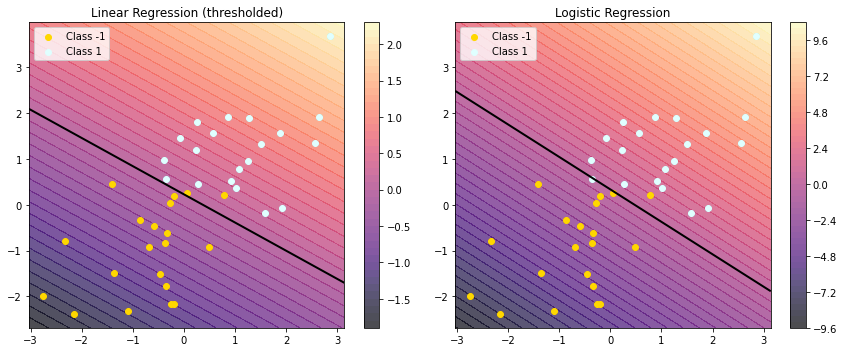

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
palette = sns.color_palette("colorblind")

from sklearn.linear_model import LinearRegression, LogisticRegression

# Seed for reproducibility
np.random.seed(42)

# Generate 2D Gaussian data for each class
n_per_class = 20
mean1 = [-1, -1]
mean2 = [1, 1]
cov = [[1, 0.5], [0.5, 1]]  # Correlated features

X_class1 = np.random.multivariate_normal(mean1, cov, n_per_class)
X_class2 = np.random.multivariate_normal(mean2, cov, n_per_class)

X = np.vstack([X_class1, X_class2])
y = np.array([-1]*n_per_class + [1]*n_per_class)

# Add outliers
n_outliers = 0
outliers_X = np.random.uniform(low=-6, high=6, size=(n_outliers, 2))
outliers_y = [1] * n_outliers #np.random.choice([-1, 1], size=n_outliers)

X = np.vstack([X, outliers_X])
y = np.concatenate([y, outliers_y])

# Train Linear Regression
lin_reg = LinearRegression().fit(X, y)

# Train Logistic Regression
log_reg = LogisticRegression().fit(X, y)

def plot_decision_boundary(ax, model, threshold_fn, title):
    ax.set_title(title)
    ax.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color="gold")#, label='Class -1')
    ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color="cyan")#, label='Class 1')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    xx, yy = np.meshgrid(np.linspace(*xlim, 200), np.linspace(*ylim, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    zz = threshold_fn(grid).reshape(xx.shape)

    # Add filled contour for decision value
    contour = ax.contourf(xx, yy, zz, levels=50, cmap="magma", alpha=0.7)

    # Add decision boundary (threshold = 0)
    ax.contour(xx, yy, zz, levels=[0], colors='black', linewidths=2)
    
    ax.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color="gold", label='Class -1')
    ax.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color="lightcyan", label='Class 1')


    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend()

    # Add colorbar
    plt.colorbar(contour, ax=ax, orientation='vertical')


# Plot both models
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

plot_decision_boundary(axs[0], lin_reg, lambda X: lin_reg.predict(X), "Linear Regression (thresholded)")
plot_decision_boundary(axs[1], log_reg, lambda X: log_reg.decision_function(X), "Logistic Regression")

plt.tight_layout()
plt.show()


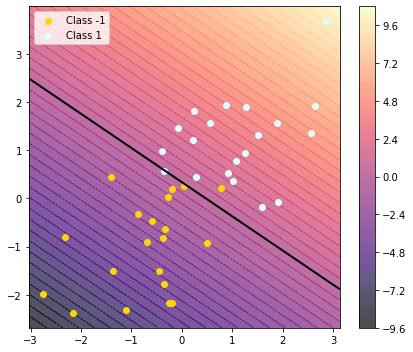

In [42]:

# Plot both models
fig, axs = plt.subplots(1, 1, figsize=(6, 5))

plot_decision_boundary(axs, log_reg, lambda X: log_reg.decision_function(X), "")
plt.tight_layout()
plt.savefig("decision-boundary.pdf", bbox_inches="tight")
plt.show()


In [25]:
log_reg.coef_

array([[1.26729426, 1.78791897]])

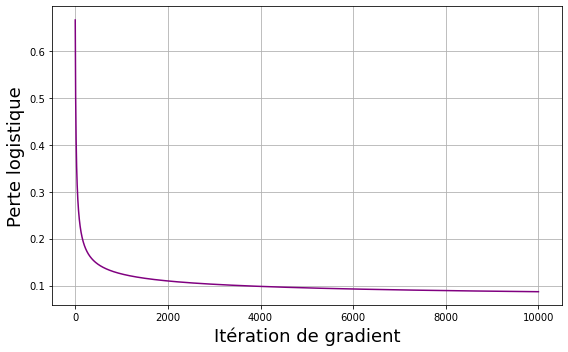

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss

# Standardize features (important for GD convergence)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Add intercept term
X_gd = np.hstack([np.ones((X_scaled.shape[0], 1)), X_scaled])
y_gd = (y == 1).astype(float)  # Convert labels to {0, 1}

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Logistic loss function
def compute_loss(w, X, y):
    z = X @ w
    p = sigmoid(z)
    return log_loss(y, p)

# Gradient of logistic loss
def compute_grad(w, X, y):
    z = X @ w
    p = sigmoid(z)
    return X.T @ (p - y) / len(y)

# Gradient descent parameters
n_steps = 10000
lr = 0.1
losses = []

# Initialize weights
w = np.zeros(X_gd.shape[1])

# Gradient descent loop
for step in range(n_steps):
    grad = compute_grad(w, X_gd, y_gd)
    w -= lr * grad
    loss = compute_loss(w, X_gd, y_gd)
    losses.append(loss)

# Plot learning curve (loss vs. steps)
plt.figure(figsize=(8, 5))
plt.plot(range(n_steps), losses, color='purple')
plt.xlabel("Itération de gradient", fontsize=18)
plt.ylabel("Perte logistique", fontsize=18)
#plt.title("Learning Curve (Gradient Descent on Logistic Regression)")
plt.grid(True)
plt.tight_layout()
plt.savefig("example-curve-train.pdf", bbox_inches="tight")
plt.show()


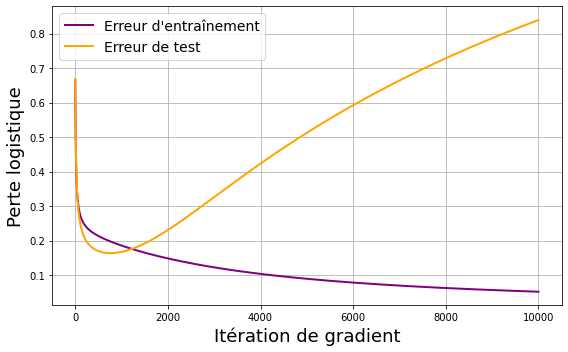

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

# Standardize features (fit on train, transform both)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Add intercept term
X_train_gd = np.hstack([np.ones((X_train_scaled.shape[0], 1)), X_train_scaled])
X_test_gd = np.hstack([np.ones((X_test_scaled.shape[0], 1)), X_test_scaled])
y_train_gd = (y_train == 1).astype(float)
y_test_gd = (y_test == 1).astype(float)

# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Logistic loss
def compute_loss(w, X, y):
    z = X @ w
    p = sigmoid(z)
    return log_loss(y, p)

# Gradient of logistic loss
def compute_grad(w, X, y):
    z = X @ w
    p = sigmoid(z)
    return X.T @ (p - y) / len(y)

# Gradient descent parameters
n_steps = 10000
lr = 0.1
train_losses = []
test_losses = []

# Initialize weights
w = np.zeros(X_train_gd.shape[1])

# Gradient descent loop
for step in range(n_steps):
    grad = compute_grad(w, X_train_gd, y_train_gd)
    w -= lr * grad
    train_loss = compute_loss(w, X_train_gd, y_train_gd)
    test_loss = compute_loss(w, X_test_gd, y_test_gd)
    train_losses.append(train_loss)
    test_losses.append(test_loss)

# Plot learning curves
plt.figure(figsize=(8, 5))
plt.plot(range(n_steps), train_losses, label="Erreur d'entraînement", color='purple', lw=2)
plt.plot(range(n_steps), test_losses, label="Erreur de test", color='orange', lw=2)
plt.xlabel("Itération de gradient", fontsize=18)
plt.ylabel("Perte logistique", fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig("example-curve-test.pdf", bbox_inches="tight")
plt.show()


Text(0.5, 0, 'Odds Ratio')

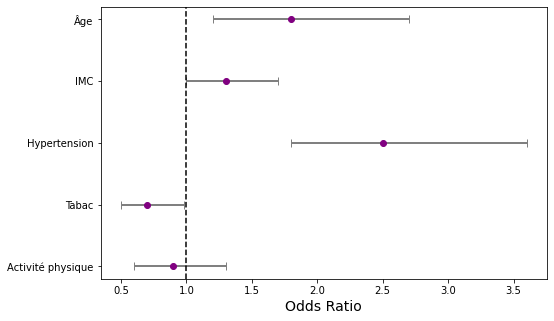

In [62]:
import numpy as np
import matplotlib.pyplot as plt

# Noms des variables/modèles
variables = ['Âge', 'IMC', 'Hypertension', 'Tabac', 'Activité physique']
n = len(variables)

# Odds ratios fictifs et intervalles de confiance
odds_ratios = np.array([1.8, 1.3, 2.5, 0.7, 0.9])
ci_lower = np.array([1.2, 1.0, 1.8, 0.5, 0.6])
ci_upper = np.array([2.7, 1.7, 3.6, 0.98, 1.3])

# Indices inversés pour avoir le haut en haut
y_pos = np.arange(n)[::-1]

# Création du plot
plt.figure(figsize=(8, 5))
plt.errorbar(odds_ratios, y_pos, xerr=[odds_ratios - ci_lower, ci_upper - odds_ratios],
             fmt='o', color='purple', ecolor='gray', elinewidth=2, capsize=4)

# Ligne verticale à OR=1 (absence d'effet)
plt.axvline(x=1, color='black', linestyle='--')

# Labels
plt.yticks(y_pos, variables)
plt.xlabel("Odds Ratio", fontsize=14)



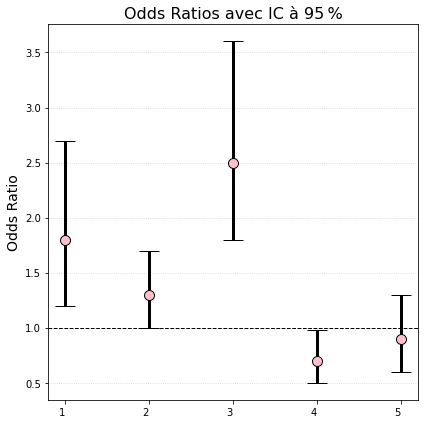

In [74]:
import numpy as np
import matplotlib.pyplot as plt

# Noms des variables/modèles
variables = ['Âge', 'IMC', 'Hypertension', 'Tabac', 'Activité physique']
n = len(variables)

# Odds ratios fictifs et intervalles de confiance
odds_ratios = np.array([1.8, 1.3, 2.5, 0.7, 0.9])
ci_lower = np.array([1.2, 1.0, 1.8, 0.5, 0.6])
ci_upper = np.array([2.7, 1.7, 3.6, 0.98, 1.3])

# Indices inversés pour affichage du bas vers le haut
x_pos = np.arange(n)

# Création du plot vertical
plt.figure(figsize=(6, 6))
plt.errorbar(x_pos, odds_ratios, 
             yerr=[odds_ratios - ci_lower, ci_upper - odds_ratios], 
             markersize=10,
             fmt='o', color='pink', ecolor='black', markeredgecolor="black", elinewidth=3, capsize=10)

# Ligne horizontale à OR=1
plt.axhline(y=1, color='black', linestyle='--', linewidth=1)

# Étiquettes des variables sur l'axe des x
plt.xticks(x_pos, [1,2,3,4,5], ha='right')
plt.ylabel("Odds Ratio", fontsize=14)
plt.title("Odds Ratios avec IC à 95 %", fontsize=16)

# Grille en arrière-plan
plt.grid(True, axis='y', linestyle=':', alpha=0.6, zorder=0)

plt.tight_layout()
plt.savefig("odds-ratio.pdf")
plt.show()
